![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# *Final Project: Contextual Bandits - Algorithm Analysis*

## Reinforcement Learning

#### Authors: **Timothy Cassel, Marvin Ernst, Oliver Tausendschön**

Date: July 2, 2025

Instructors: *Hamish Flynn and Vincent Adam*

In this notebook, we evaluate and analyze contextual bandit algorithms using the **Open Bandit Dataset (OBD)**. The main focus lies on implementing and benchmarking **Thompson Sampling (TS)** variants under realistic logged feedback conditions.

We perform the following:
- Implement **Thompson Sampling for linear bandits** using Bayesian linear regression
- Compare TS to **LinUCB** and **Random** policies
- Evaluate offline performance using:
  - **Inverse Propensity Scoring (IPS)**
  - **Doubly Robust (DR)** estimators
- Assess exploration behavior and learning stability
 
This notebook provides additional insights into the empirical behavior of Bayesian bandit strategies and whether **TS** can outperform **UCB** in sparse, realistic environments.

---

## 1. Setup and Imports

Importing the relevant libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict
import random
import os
from linucb import linucb_all
from ts_linear import ts_linear_all
from evaluate.evaluate_random_policy import evaluate_random_policy
from evaluate.evaluate_all_policies import evaluate_policy, evaluate_ts_lambda
import glob

Set seeds for reproducibility:

In [2]:
np.random.seed(42)
random.seed(42)

## 2. Load Processed Data

(We have the preprocessed version in `processed_top3/`)

In [3]:
X_context = np.load("processed_top3/context_reduced.npy")
actions = np.load("processed_top3/actions.npy")
rewards = np.load("processed_top3/rewards.npy")
pscores = np.load("processed_top3/pscores.npy")
meta = np.genfromtxt("processed_top3/meta.txt", skip_header=1)

n_rounds, context_dim = X_context.shape
n_arms = len(np.unique(actions))

print(f"Context shape: {X_context.shape}, #Arms: {n_arms}")

Context shape: (53988, 12), #Arms: 3


## 3. Re-run LinUCB 

We take this for comparison to the TS version.

We use a LinUCB wrapper:

In [4]:
def run_linucb(X, a_logged, r_logged, seed, alpha=1.0):
    n_arms = len(np.unique(a_logged))
    A = [np.identity(X.shape[1]) for _ in range(n_arms)]
    b = [np.zeros(X.shape[1]) for _ in range(n_arms)]
    return np.array(linucb_all(X, a_logged, r_logged, A, b, alpha)["chosen_actions"])

Evaluation:

In [5]:
dr_linucb = evaluate_policy("LinUCB", lambda X, a, r, s: run_linucb(X, a, r, s, alpha=1.0), save_path=None)

## 4. Thompson Sampling with Linear Models

We now implement **contextual Thompson Sampling (TS)** using a Bayesian linear regression formulation.

TS maintains a posterior distribution over the weight vector $\theta_a$ for each arm and samples from this distribution to select actions. In each round, it draws a sample $\tilde{\theta}_a$ for each arm, computes the estimated reward $\tilde{r}_a = x^\top \tilde{\theta}_a$, and selects the arm with the highest sampled reward.

This stochastic action selection naturally balances **exploration** (sampling new parameters) and **exploitation** (choosing high-reward arms).

We evaluate the standard TS algorithm with ridge priors:
- Prior: $\theta_a \sim \mathcal{N}(0, \lambda^{-1} I)$
- Posterior updated using ridge regression

After running the TS policy, we use the **Doubly Robust (DR)** estimator to compare its performance against LinUCB.

We save the algorithm in `ts_linear.py`.

## 5. Evaluate Thompson Sampling (DR)

We now evaluate the TS policy using the **Doubly Robust estimator**, consistent with our previous LinUCB analysis.

This enables fair comparison, particularly under sparse and partial feedback conditions.

(Note, the evaluation is in line with what we ahve done previoursly but now in a safer way.)

We also use a Wrapper for this:

In [6]:
def run_ts(X, a_logged, r_logged, seed, alpha=1.0):
    return np.array(ts_linear_all(X, a_logged, r_logged, alpha=alpha)["chosen_actions"])

Evaluation:

In [7]:
dr_ts = evaluate_policy("TS", lambda X, a, r, s: run_ts(X, a, r, s, alpha=1.0), save_path=None)

##### **True Baseline**

We simulate a new random policy, etc. - same as in the UCB notebook. We also do it the safe way here.

We use a Wrapper:

In [8]:
def run_random(X, a_logged, r_logged, seed):
    rng = np.random.default_rng(seed)
    return rng.integers(0, len(np.unique(a_logged)), size=len(a_logged))

Evaluation:

In [9]:
dr_random = evaluate_policy("Random", run_random, save_path=None)

**Comparison**

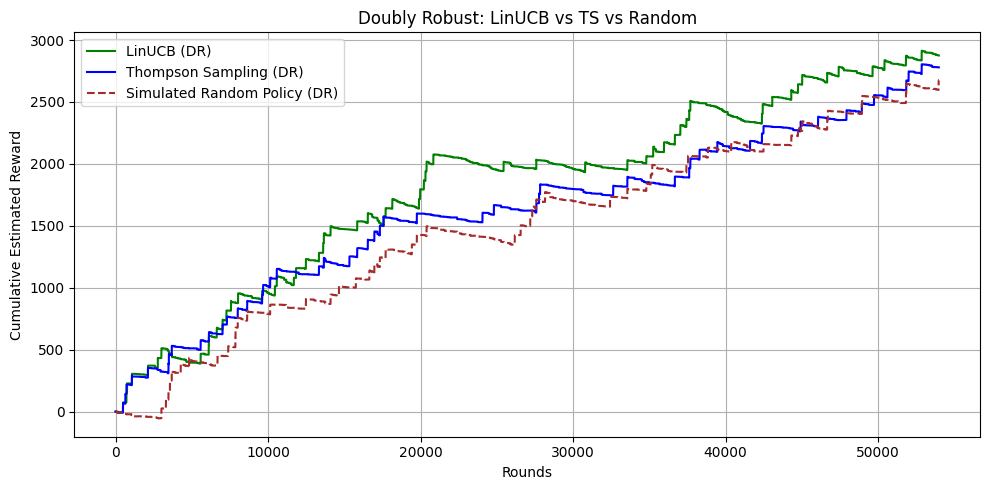

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(dr_linucb), label="LinUCB (DR)", color="green")
plt.plot(np.cumsum(dr_ts), label="Thompson Sampling (DR)", color="blue")
plt.plot(np.cumsum(dr_random), label="Simulated Random Policy (DR)", linestyle="--", color="brown")
plt.title("Doubly Robust: LinUCB vs TS vs Random")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Estimated Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We see that in a single run, **Thompson Sampling (TS)** appears to outperform **LinUCB**, even though both perform worse than the **simulated random policy** when evaluated using the **Doubly Robust (DR)** estimator.

In particular, **LinUCB with $\alpha = 1.0$** performs significantly worse, highlighting that strong exploration is detrimental in this sparse reward environment. However, **TS still fails to beat the random baseline**, which limits its practical promise.

## 6. Averaged Evaluation over 30 Simulations

To reduce the variance of single-run evaluations, we now compare LinUCB and Thompson Sampling (TS) under multiple exploration parameters across **30 randomized runs**.

For each run, we:
- Shuffle the context-action-reward dataset
- Train a fresh reward model (Random Forest)
- Apply **Doubly Robust (DR)** estimation to evaluate each policy

We include:
- **LinUCB** with $\alpha \in \{0.0, 0.1, 0.25\}$
- **Thompson Sampling (TS)** with $\alpha \in \{0.25, 0.5, 1.0\}$
- A **simulated random policy** (uniform arm selection)

Each policy's **cumulative reward curve** is averaged across all runs.

> Note: Unlike in LinUCB where $\alpha = 0$ implies purely greedy behavior, in TS, $\alpha = 0$ is invalid. Instead, it controls posterior variance: larger $\alpha$ implies greater randomness in sampling.

This evaluation allows a more stable and fair comparison between deterministic and stochastic exploration strategies in contextual bandits.

Setup:

In [ ]:
linucb_alphas = [0.0, 0.1, 0.25]
ts_alphas = [0.25, 0.5, 1.0]
all_labels = [f"LinUCB alpha={a}" for a in linucb_alphas] + [f"TS alpha={a}" for a in ts_alphas] + ["Simulated Random Policy"]

average_curves = {label: np.zeros(n_rounds) for label in all_labels}
n_runs = 30

We define new concise wrappers:

In [12]:
def run_linucb_alpha(alpha):
    return lambda X, a, r, seed: np.array(
        linucb_all(X, a, r,
                   A=[np.identity(X.shape[1]) for _ in range(len(np.unique(a)))],
                   b=[np.zeros(X.shape[1]) for _ in range(len(np.unique(a)))],
                   alpha=alpha)["chosen_actions"]
    )

def run_ts_alpha(alpha):
    return lambda X, a, r, seed: np.array(ts_linear_all(X, a, r, alpha=alpha)["chosen_actions"])

def run_random(X, a_logged, r_logged, seed):
    rng = np.random.default_rng(seed)
    return rng.integers(0, len(np.unique(a_logged)), size=len(a_logged))

Now, we run over seeds:

In [16]:
for seed in range(n_runs):
    for alpha in linucb_alphas:
        dr = evaluate_policy(
            policy_label=f"LinUCB alpha={alpha}",
            chosen_actions_fn=run_linucb_alpha(alpha),
            save_path=f"results/dr_curve_linucb_alpha{alpha}_seed{seed}.npy",
            seed=seed,
        )
        np.save(f"results/dr_curve_linucb_alpha{alpha}_seed{seed}.npy", dr)

    for alpha in ts_alphas:
        dr = evaluate_policy(
            policy_label=f"TS alpha={alpha}",
            chosen_actions_fn=run_ts_alpha(alpha),
            save_path=f"results/dr_curve_ts_alpha{alpha}_seed{seed}.npy",
            seed=seed,
        )
        np.save(f"results/dr_curve_ts_alpha{alpha}_seed{seed}.npy", dr)

    dr = evaluate_policy(
        policy_label="Simulated Random Policy",
        chosen_actions_fn=run_random,
        save_path=f"results/dr_curve_random_seed{seed}.npy",
        seed=seed,
    )
    np.save(f"results/dr_curve_random_seed{seed}.npy", dr)

We create this helper to load and average curves per label:

In [14]:
def average_saved_curves(label_prefix, n_runs, n_rounds):
    total = np.zeros(n_rounds)
    for seed in range(n_runs):
        curve = np.load(f"results/{label_prefix}_seed{seed}.npy")
        total += np.cumsum(curve)
    return total / n_runs

Now we build our full dictionary:

In [17]:
average_curves = {}
for alpha in linucb_alphas:
    label = f"LinUCB alpha={alpha}"
    prefix = f"dr_curve_linucb_alpha{alpha}"
    average_curves[label] = average_saved_curves(prefix, n_runs, n_rounds)

for alpha in ts_alphas:
    label = f"TS alpha={alpha}"
    prefix = f"dr_curve_ts_alpha{alpha}"
    average_curves[label] = average_saved_curves(prefix, n_runs, n_rounds)

average_curves["Simulated Random Policy"] = average_saved_curves("dr_curve_random", n_runs, n_rounds)

**Comparison**

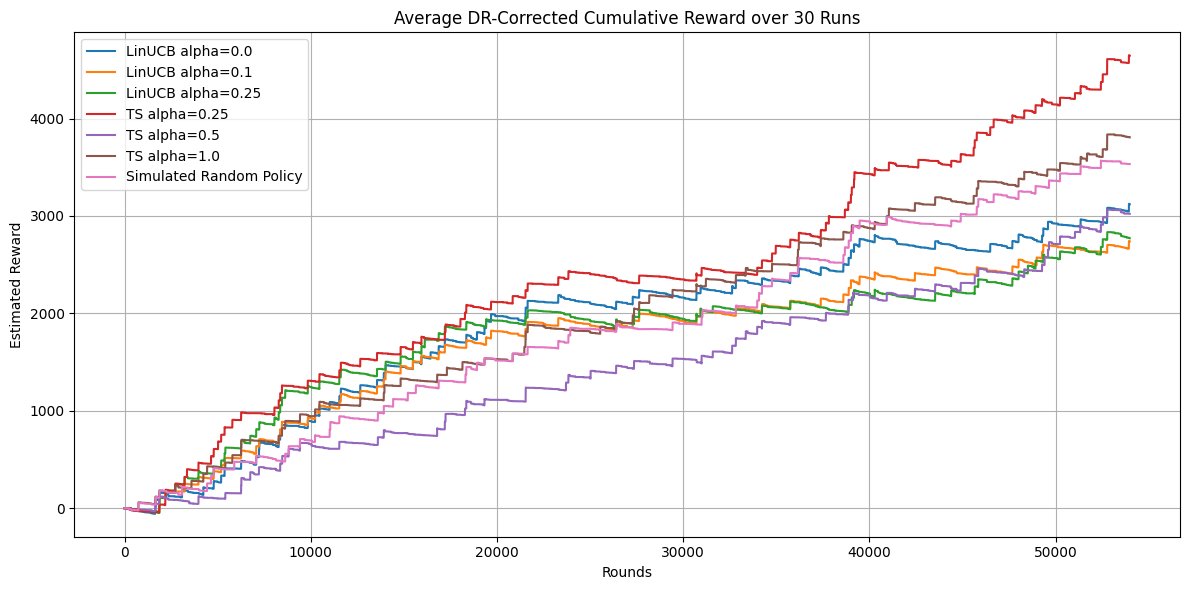

In [18]:
plt.figure(figsize=(12, 6))
for label, curve in average_curves.items():
    plt.plot(curve, label=label)
plt.title("Average DR-Corrected Cumulative Reward over 30 Runs")
plt.xlabel("Rounds")
plt.ylabel("Estimated Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

From this we can see (analysis needed).





## 7. Varying Prior Strength: Different $\lambda$ for Best-Performing TS Variant

In addition to tuning the exploration factor $\alpha$, we now explore how the **prior strength parameter** $\lambda$ affects Thompson Sampling (TS) performance.

We fix the best-performing configuration from earlier - namely **TS with $\alpha = 0.25$** - and evaluate the effect of varying $\lambda$ across:

- $\lambda = 0.1$ (very weak prior)
- $\lambda = 1.0$ (default prior used in earlier experiments)
- $\lambda = 10.0$ (strong prior)

Recall that TS maintains a Bayesian posterior over arm-specific regression weights:

$$
\theta_a \sim \mathcal{N}(\mu_a, \Sigma_a) \quad \text{with} \quad \Sigma_a = \alpha^2 A_a^{-1}, \quad A_a = \lambda I + \sum_{i \in \mathcal{D}_a} x_i x_i^\top
$$

Thus, $\lambda$ controls how **confident** the model is in its prior:
- Smaller $\lambda$: more flexible, faster to adapt (but higher variance)
- Larger $\lambda$: more stable, more prior-conservative

We average DR-corrected cumulative rewards over **30 random permutations** of the dataset and compare:

- Each TS variant with different $\lambda$
- **LinUCB ($\alpha = 0.0$)** - the best UCB variant
- **Simulated Random Policy (DR)** - baseline

In [ ]:
n_runs = 30
n_rounds = len(X_context)
lambda_vals = [0.1, 10.0]
fixed_alpha = 0.25

Save new TS lambda curves:

In [20]:
for lam in lambda_vals:
    for seed in range(n_runs):
        dr = evaluate_ts_lambda(fixed_alpha, lam, seed)
        np.save(f"results/dr_ts_alpha{fixed_alpha}_lambda{lam}_seed{seed}.npy", dr)

Load all:

In [22]:
ts_lambda_curves = {
    f"TS alpha=0.25, lambda=0.1": average_saved_curves("dr_ts_alpha0.25_lambda0.1", n_runs, n_rounds),
    f"TS alpha=0.25, lambda=1.0": average_saved_curves("dr_curve_ts_alpha0.25", n_runs, n_rounds),  # legacy name
    f"TS alpha=0.25, lambda=10.0": average_saved_curves("dr_ts_alpha0.25_lambda10.0", n_runs, n_rounds),
}

linucb_greedy_curve = average_saved_curves("dr_curve_linucb_alpha0.0", n_runs, n_rounds)
random_sim_curve = average_saved_curves("dr_curve_random", n_runs, n_rounds)

**Comparison**

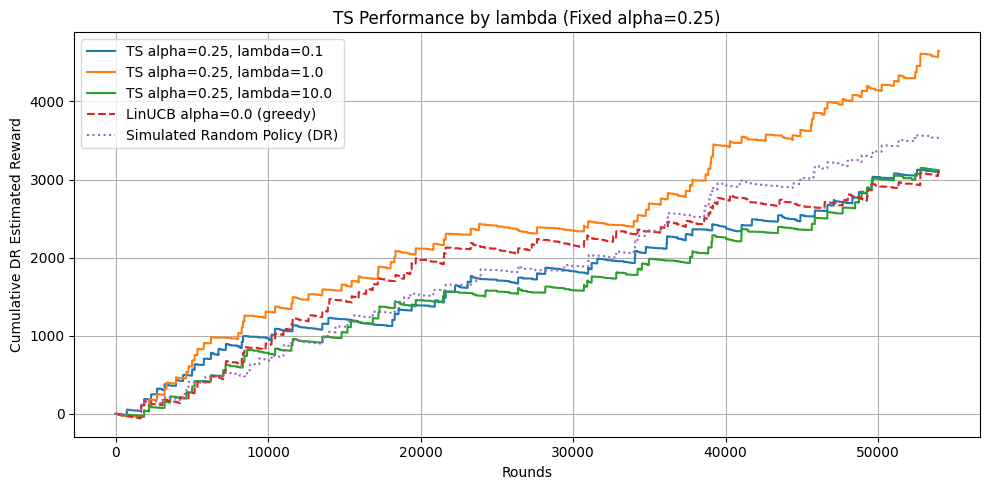

In [24]:
plt.figure(figsize=(10, 5))
for label, curve in ts_lambda_curves.items():
    plt.plot(curve, label=label)
plt.plot(linucb_greedy_curve, label="LinUCB alpha=0.0 (greedy)", linestyle="--")
plt.plot(random_sim_curve, label="Simulated Random Policy (DR)", linestyle=":")
plt.title("TS Performance by lambda (Fixed alpha=0.25)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative DR Estimated Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

From this we can see - observations needed!

## 8. Additional - LinUCB (only) - TRUE Averages

Save per-seed results:

In [ ]:
for seed in range(n_runs):
    for alpha in linucb_alphas:
        dr = evaluate_policy(
            policy_label=f"LinUCB alpha={alpha}",
            chosen_actions_fn=run_linucb_alpha(alpha),
            save_path=f"results/dr_curve_linucb_alpha{alpha}_seed{seed}.npy",
            seed=seed,
        )
        np.save(f"results/dr_curve_linucb_alpha{alpha}_seed{seed}.npy", dr)

    dr = evaluate_policy(
        policy_label="Simulated Random Policy",
        chosen_actions_fn=run_random,
        save_path=f"results/dr_curve_random_seed{seed}.npy",
        seed=seed,
    )
    np.save(f"results/dr_curve_random_seed{seed}.npy", dr)

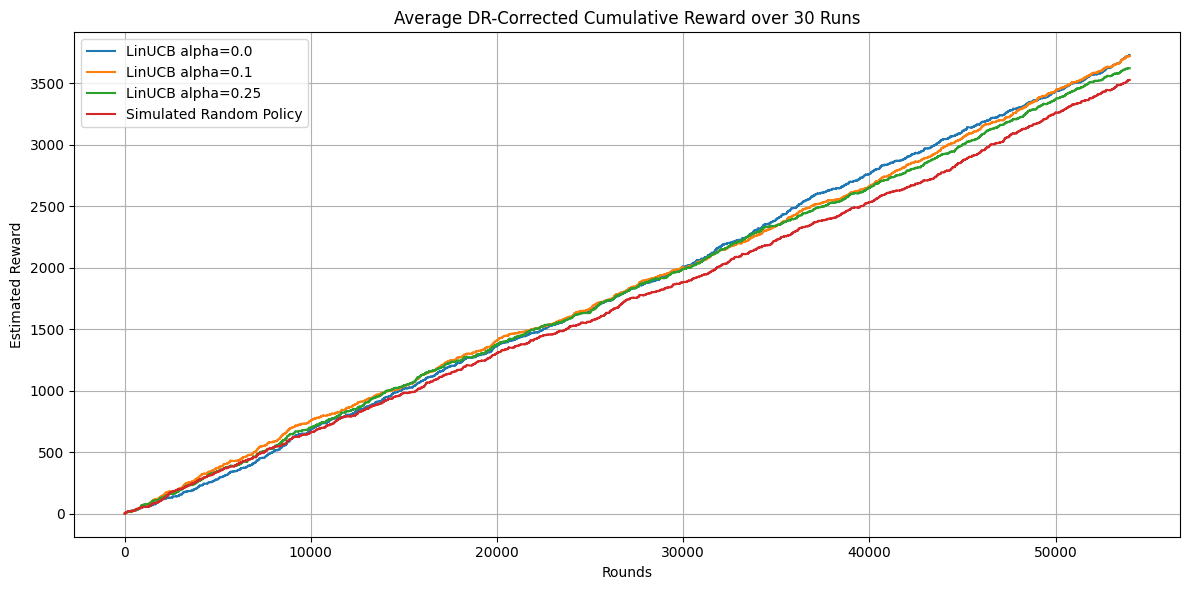

In [ ]:
average_curves = {}
n_rounds = len(np.load("processed_top3/context_reduced.npy"))

for alpha in linucb_alphas:
    label = f"LinUCB alpha={alpha}"
    prefix = f"dr_curve_linucb_alpha{alpha}"
    average_curves[label] = average_saved_curves(prefix, n_runs, n_rounds)

average_curves["Simulated Random Policy"] = average_saved_curves("dr_curve_random", n_runs, n_rounds)

plt.figure(figsize=(12, 6))
for label, curve in average_curves.items():
    plt.plot(curve, label=label)
plt.title("Average DR-Corrected Cumulative Reward over 30 Runs")
plt.xlabel("Rounds")
plt.ylabel("Estimated Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()